In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:

# loading training datasets
path = r"C:\Users\Suman Pokhrel\Codesoft\ML\movie classifier\Genre Classification Dataset\train_data.txt"
datasets = pd.read_csv(path,  sep = ':::', names = ['Title', 'Genre', 'Description'], engine = 'python')
datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [3]:
datasets.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [4]:
# checking if the dataset contains null data or not
datasets.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [5]:
# printing few data in the list
datasets.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [6]:
# loading the testing datasets
test_data = r"C:\Users\Suman Pokhrel\Codesoft\ML\movie classifier\Genre Classification Dataset\test_data.txt"
test_data = pd.read_csv(test_data, sep = ":::", names = ["Title", "Genre", "Description"], engine = "python")
test_data.head()

,Title,Genre,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [26]:
# loadding test solution datasets
test_soln_data = r"C:\Users\Suman Pokhrel\Codesoft\ML\movie classifier\Genre Classification Dataset\test_data_solution.txt"
test_soln_data = pd.read_csv(test_soln_data, sep=":::", names=['Id', 'Title', 'Description'], engine='python')
test_soln_data.drop(test_soln_data.columns[[0, 2]], axis=1, inplace=True)
test_soln_data.rename(columns = {'Title':'Actual Genre'}, inplace = True) 
test_soln_data.head(3)

,Actual Genre
1,thriller
2,comedy
3,documentary


# EDA & Visualization

Text(0, 0.5, 'Genre')

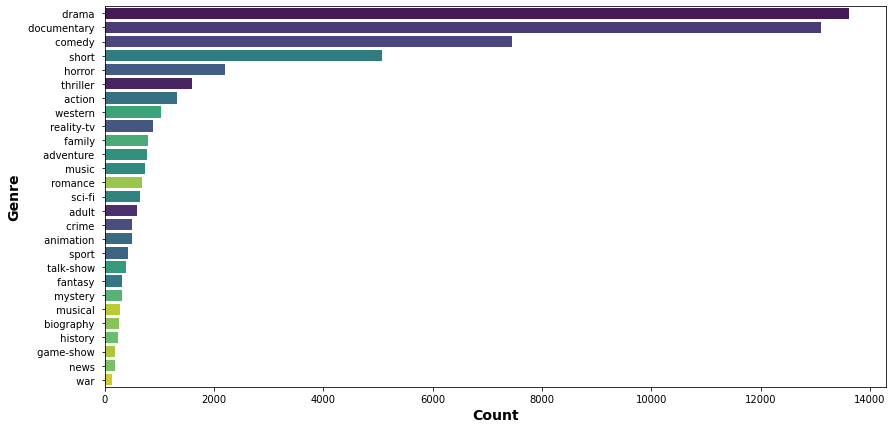

In [7]:
# plotting the dataset into different graphs

plt.figure(figsize = (14,7))
sns.countplot(data=datasets, y='Genre', hue='Genre', order=datasets['Genre'].value_counts().index,palette='viridis',  legend = False)
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')

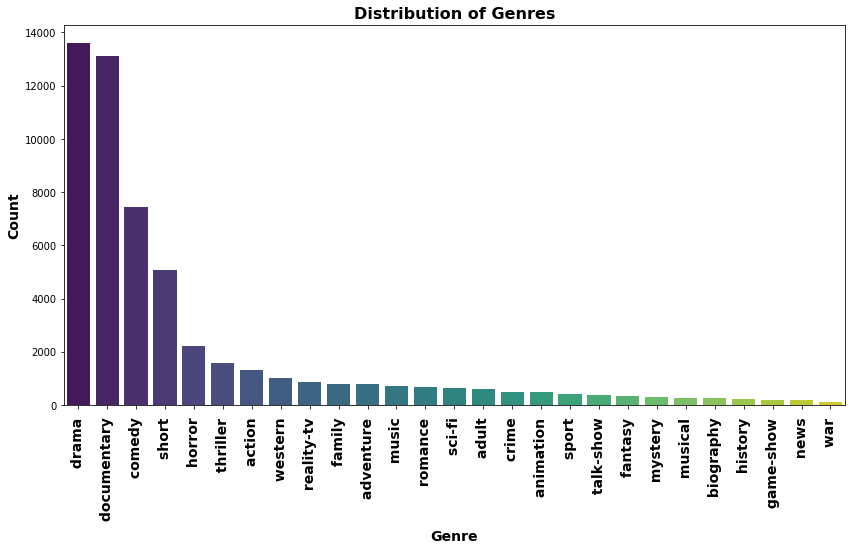

In [8]:
plt.figure(figsize= (14, 7))
counts = datasets['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts,hue = counts.index, palette='viridis', legend = False)
plt.xlabel('Genre', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

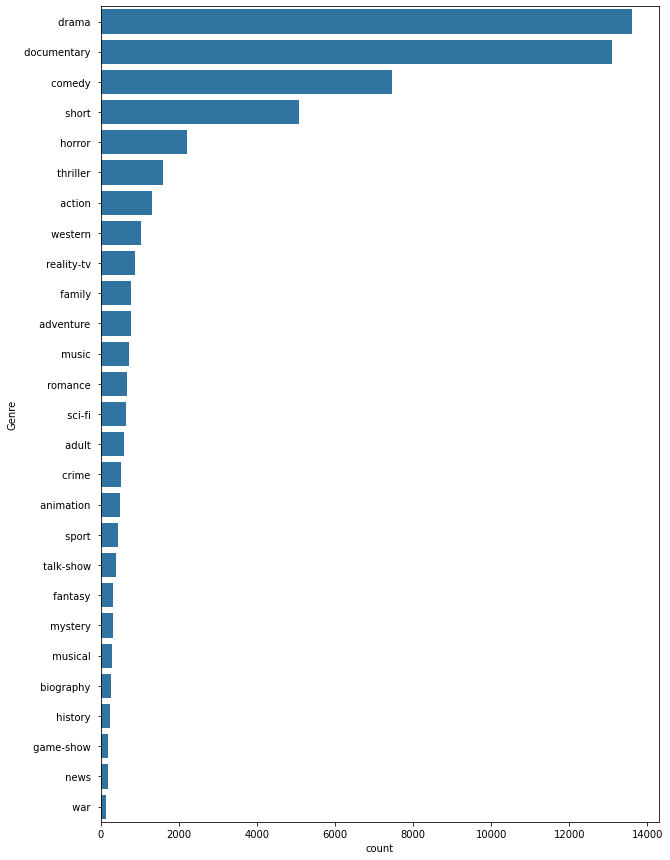

In [9]:
plt.figure(figsize=(10,15))
sns.countplot(data=datasets, y='Genre', order= datasets['Genre'].value_counts().index)
plt.show()

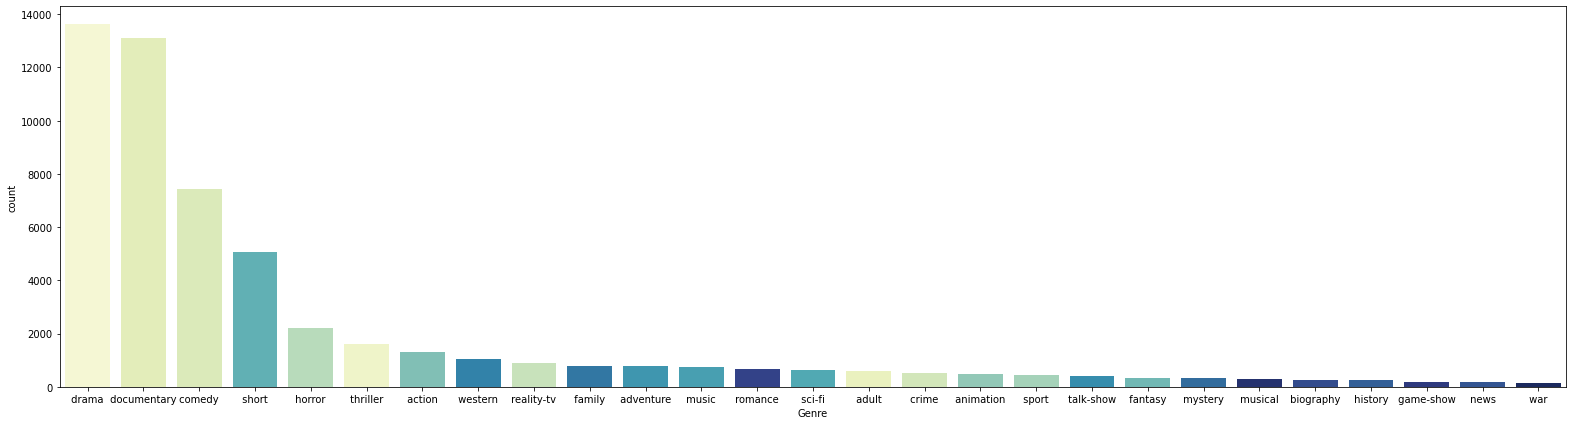

In [10]:
plt.figure(figsize=(27,7))
sns.countplot(data=datasets, x="Genre",hue= 'Genre', legend = False, order= datasets["Genre"].value_counts().index, palette = "YlGnBu")
plt.show()

In [11]:
#Finda any null value
datasets.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

# Data Preprocessing and Text Cleaning

In [12]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_textt function
def clean_text(text):
    text = text.lower() #Lowercase all characters
    text = re.sub(r'@\S+', '', text) # Remove Twitter handles
    text = re.sub(r'http\S+', '', text) #Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)#Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')
    #Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    #Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  #Remove repeated/leading/trailing spaces
    return text

#Apply the clean_text function to the 'Description' column in the training and test data
datasets['Text_cleaning'] = datasets['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

In [13]:
# Droping the redundant data
print("shape before drop nulls",datasets.shape)
datasets = datasets.drop_duplicates()
print("shape after drop nulls",datasets.shape)

shape before drop nulls (54214, 4)
shape after drop nulls (54214, 4)


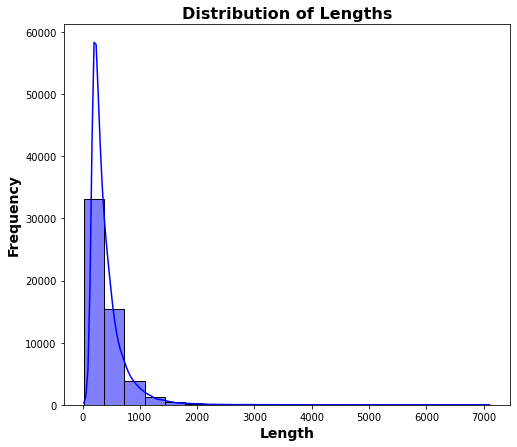

In [14]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

# Calculate the length of cleaned text
datasets['length_Text_cleaning'] = datasets['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=datasets, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

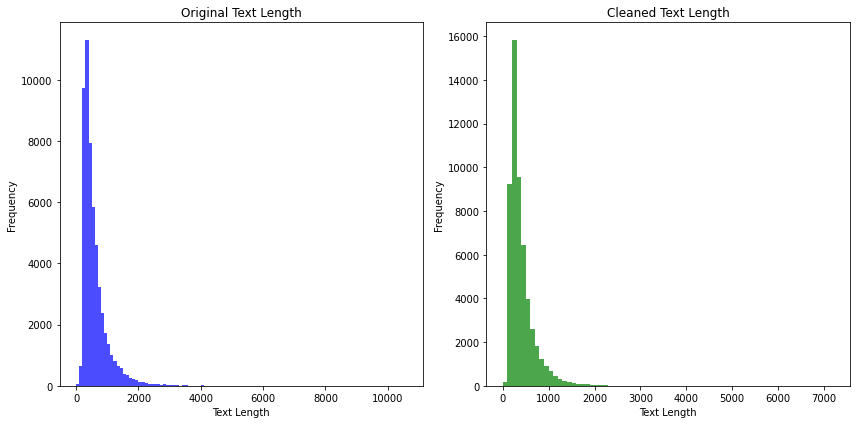

In [15]:
# Create histograms to visualize the distribution of text lengths before and after cleaning

# Set up the figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Original text length distribution
plt.subplot(1, 2, 1)
original_lengths = datasets['Description'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='blue', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Subplot 2: Cleaned text length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = datasets['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [16]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(datasets['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

In [17]:
# Split the data into training and validation sets
X = X_train
y = datasets['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
import warnings
warnings.filterwarnings("ignore")

# Initialize and train a Multinomial Naive Bayes Classifier
clf_NB = MultinomialNB()
clf_NB.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = clf_NB.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.44526422576777647
               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.61      0.04      0.07      1443
       crime        0.00      0.00      0.00       107
 documentary        0.54      0.90      0.67      2659
       drama        0.38      0.88      0.53      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00        50
     mystery        0.0

In [19]:
accuracy_NB = accuracy_score(y_val, y_pred)
accuracy_NB

0.44526422576777647

In [21]:
# Initialize and train a Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

clf_logreg = LogisticRegression(multi_class='multinomial', solver='sag')
clf_logreg.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = clf_logreg.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.5795444065295582
               precision    recall  f1-score   support

      action        0.61      0.22      0.32       263
       adult        0.86      0.17      0.28       112
   adventure        0.45      0.10      0.16       139
   animation        0.67      0.02      0.04       104
   biography        0.00      0.00      0.00        61
      comedy        0.52      0.59      0.55      1443
       crime        1.00      0.01      0.02       107
 documentary        0.65      0.87      0.74      2659
       drama        0.53      0.81      0.64      2697
      family        0.50      0.05      0.10       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.92      0.30      0.45        40
     history        0.00      0.00      0.00        45
      horror        0.67      0.55      0.60       431
       music        0.71      0.38      0.49       144
     musical        0.00      0.00      0.00        50
     mystery        0.00

In [22]:
accuracy_logreg = accuracy_score(y_val, y_pred)
accuracy_logreg

0.5795444065295582

In [23]:
# Use the trained model to make predictions on the test data
X_test_predictions = clf_NB.predict(X_test)
test_data['Predicted_Genre_NB'] = X_test_predictions

In [24]:
# Use the trained model to make predictions on the test data
X_test_predictions = clf_logreg.predict(X_test)
test_data['Predicted_Genre_LR'] = X_test_predictions

In [27]:
# Save the test_data DataFrame with predicted genres to a CSV file
test_data.to_csv('predicted_genres.csv', index=False)

# Add actual genre column to predicted dataFrame
extracted_col = test_soln_data["Actual Genre"]
test_data.insert(5, "Actual Genre", extracted_col)

In [28]:
# Display the 'test_data' DataFrame with predicted and actual genres
test_data.head()

,Title,Genre,Description,Text_cleaning,Predicted_Genre_NB,Actual Genre,Predicted_Genre_LR
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...,drama,NaN,drama
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...,drama,thriller,drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...,documentary,comedy,documentary
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...,drama,documentary,drama
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...,drama,drama,drama


In [29]:
count_same_values_NB = (test_data['Predicted_Genre_NB'] == test_data['Actual Genre']).sum()
count_same_values_LR = (test_data['Predicted_Genre_LR'] == test_data['Actual Genre']).sum()

print("Number of samples where Naive Bayes Classifier predicted accurately:", count_same_values_NB)
print("Number of samples where Logistic Regression Classifier predicted accurately:", count_same_values_LR)

Number of samples where Naive Bayes Classifier predicted accurately: 13318
Number of samples where Logistic Regression Classifier predicted accurately: 10886


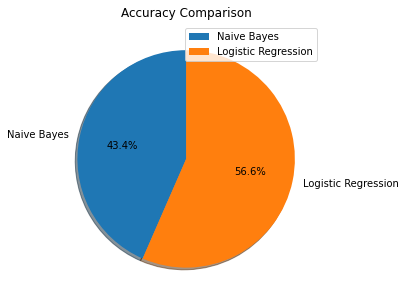

In [30]:
sum = accuracy_NB + accuracy_logreg
size1 = (accuracy_NB/sum)
size2 = (accuracy_logreg/sum)
labels = ['Naive Bayes', 'Logistic Regression']
sizes = [size1, size2]

# Plotting the pie chart
plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, shadow = True)
plt.title('Accuracy Comparison')
plt.legend()
plt.show()

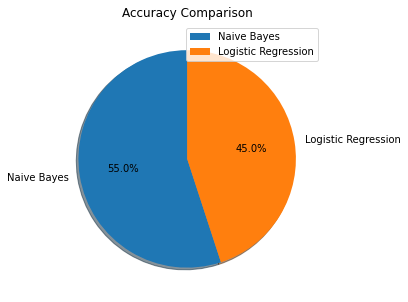

In [31]:
sum = count_same_values_NB + count_same_values_LR
portion1 = (count_same_values_NB/sum)
portion2 = (count_same_values_LR/sum)
labels = ['Naive Bayes', 'Logistic Regression']
sizes = [portion1, portion2]

# Plotting the pie chart
plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, shadow = True)
plt.title('Accuracy Comparison')
plt.legend()
plt.show()

# Completed